In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
cyc_DIR = "../data/cycling/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
# parameter_values.search("Li")

In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 6

## Load eSOH Data and OCV Data

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/100")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
        "Positive electrode LAM constant exponential term": 1.1992,
        "Negative electrode LAM constant exponential term": 1.1992,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Positive electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Positive electrode diffusion coefficient activation energy [J.mol-1]": 0,
        "Negative electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Negative electrode diffusion coefficient activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [9]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

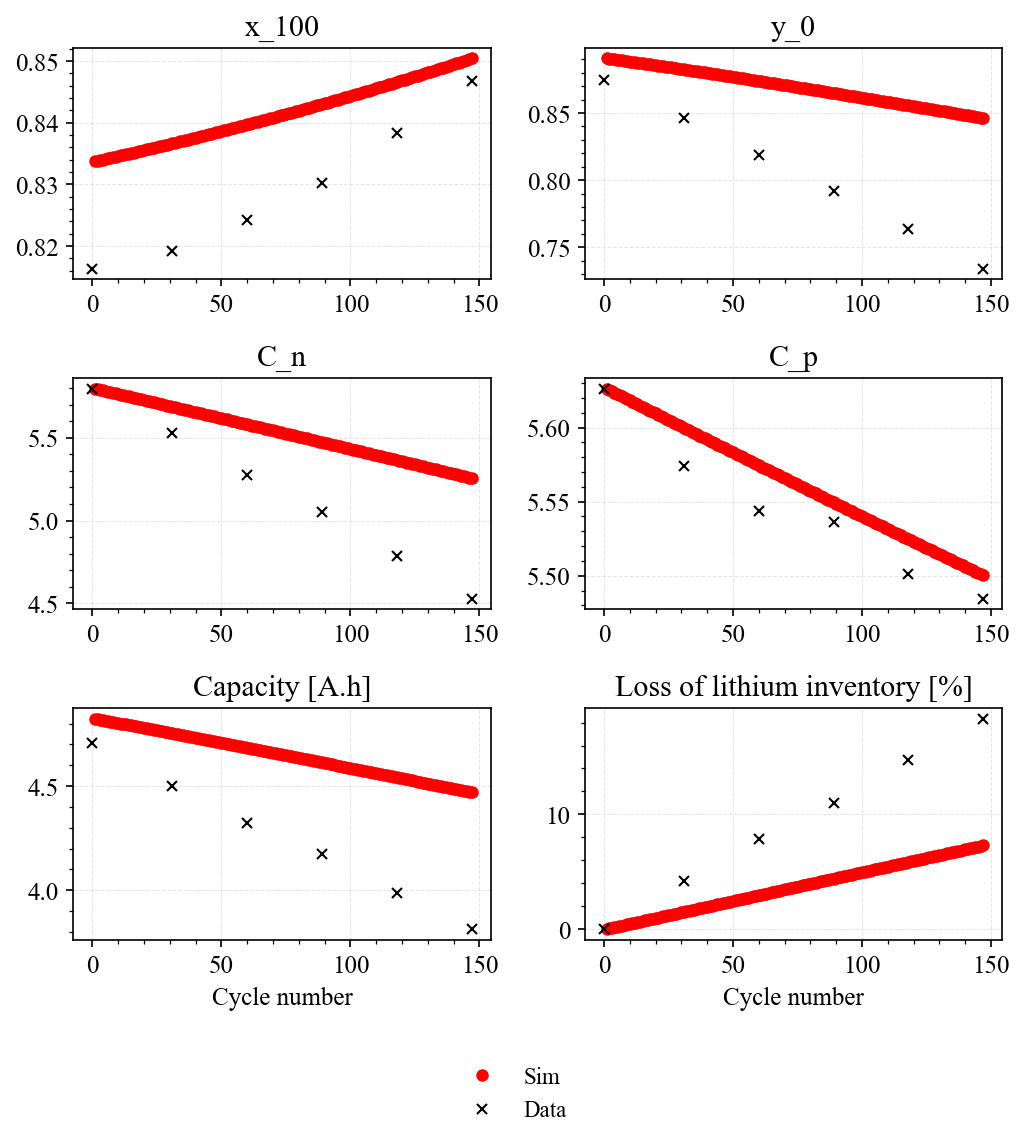

In [10]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [11]:
# fgdfdfg

# Parameter Fitting

## List of Initial Conditions

In [12]:
ic = 1
blam_p = [1e-6,1e-7,1e-8]
blam_n = [1e-5,1e-6,1e-7]
k_pl = 1e-9
 # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","x_100","y_0"]
    # weights = [1,1/20,5,5]

In [13]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # # weights = [1,1/20]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]
    weights = [1,1/20,1,1]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1,drive_cycle=None)
def prediction_error(x):
    try:
        out=[]
        for cell in [3,6]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            # print(f"Cell: {cell_no}")
            if cell == 19:
                experiment = pybamm.Experiment(
                    [
                        ("Run DriveCycle (A)",
                        "Rest for 5 min",
                        "Charge at "+c_rate_c+" until 4.2V", 
                        "Hold at 4.2V until C/50")
                    ] *dfe.N.iloc[-1],
                    # ] *1,
                    drive_cycles={"DriveCycle": drive_cycle},
                    termination="50% capacity",
                #     cccv_handling="ode",
                )
            else:
                experiment = pybamm.Experiment(
                    [
                        ("Discharge at "+c_rate_d+dis_set,
                        "Rest for 5 min",
                        "Charge at "+c_rate_c+" until 4.2V", 
                        "Hold at 4.2V until C/50")
                    ] *dfe.N.iloc[-1],
                    termination="50% capacity",
                #     cccv_handling="ode",
                )
            # print(f"Model")
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
            # print(f"Objective")
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            out_t[-1] = 5*out_t[-1]
            # print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out=[]
        for cell in [3,6]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0,1.0])
    # print(prediction_error(x0))
    lower = np.array([1e-2, 1e-2, 0.51, 1e-1])
    upper = np.array([1e+2, 1e+2, 1.5, 1e+1])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    df['x_3'][0]=round(xsol[3],4)*k_pl
    df['obj'][0]=soln_dfols.f
    return xsol,df

In [14]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','obj'], index=[0])

In [15]:
train_len = len(N)
x,df_x = sim_train(df_x)

x=[1. 1. 1. 1.], norm=3.355476955519808
x=[0.98093535 0.96318162 0.91215093 1.02373787], norm=3.293071632768786
x=[1.07382874 0.93381807 1.00924072 0.99084148], norm=3.367141502866859
x=[1.06138166 1.06421623 0.95611419 0.98648695], norm=3.3130243242484667
x=[1.02044867 1.01185897 1.01646768 1.09576029], norm=3.350574923184745
x=[0.98943004 0.97959794 0.81583085 1.04325167], norm=3.181282207880609
x=[1.01085968 1.04124523 0.51       1.29266673], norm=2.1359893432100145
x=[0.86921574 1.99734588 0.51       2.56773871], norm=1.2147086804285097
x=[1.00839694 0.01       0.51       2.64882262], norm=3.094146964604919
x=[1.20655266 1.52117387 0.51       2.18096182], norm=1.5277432246412515
x=[0.77863554 1.85410635 0.54945385 2.66508323], norm=1.6579948264920625
x=[1.48624565 1.9544155  0.51       2.23977011], norm=1.1323221256605953
x=[1.38983742 1.76482718 0.51       1.57276632], norm=1.3297443702910634
x=[1.52793435 2.30192314 0.51       2.23397522], norm=0.9675080313035709
x=[1.56889798 2.

In [16]:
sim_des="plating_mech_3_6_new_mech_plating_resistance"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

In [17]:
print(f"{df_x['x_0'][0]},{df_x['x_1'][0]},{df_x['x_2'][0]},{df_x['x_3'][0]}")

1.5699e-07,2.466e-06,1.02,1.7377000000000001e-09


In [21]:
def plotcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n_loss", "C_p_loss", "Capacity Retention [%]", "Loss of lithium inventory [%]"]
    all_sumvars_dict["C_n_loss"] = (all_sumvars_dict["C_n"][0]-all_sumvars_dict["C_n"])/all_sumvars_dict["C_n"][0]*100
    all_sumvars_dict["C_p_loss"] = (all_sumvars_dict["C_p"][0]-all_sumvars_dict["C_p"])/all_sumvars_dict["C_p"][0]*100
    all_sumvars_dict["Capacity Retention [%]"] = (all_sumvars_dict["Capacity [A.h]"])/all_sumvars_dict["Capacity [A.h]"][0]*100
    esoh_data["C_n_loss"] = (esoh_data["C_n"][0]-esoh_data["C_n"])/esoh_data["C_n"][0]*100
    esoh_data["C_p_loss"] = (esoh_data["C_p"][0]-esoh_data["C_p"])/esoh_data["C_p"][0]*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        # if k ==2 or k==3:
        #     ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

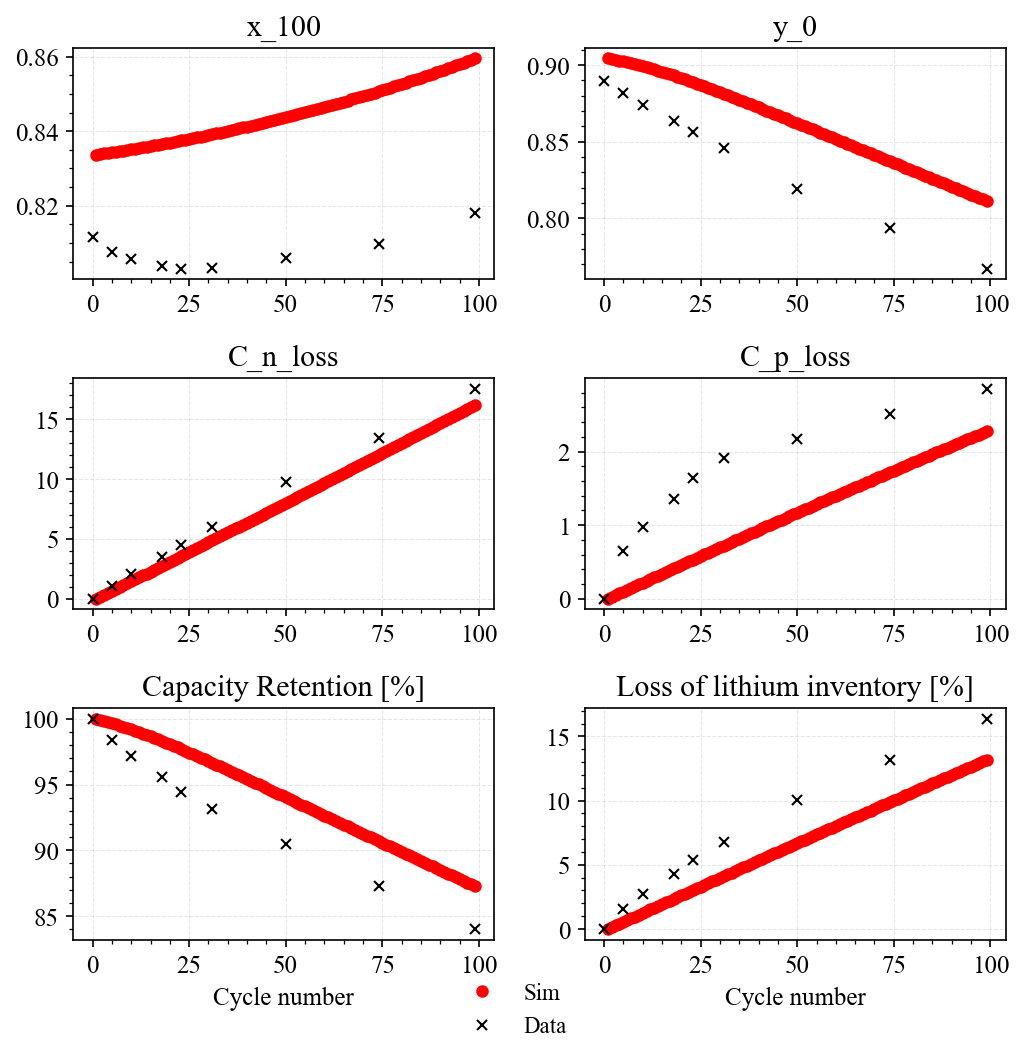

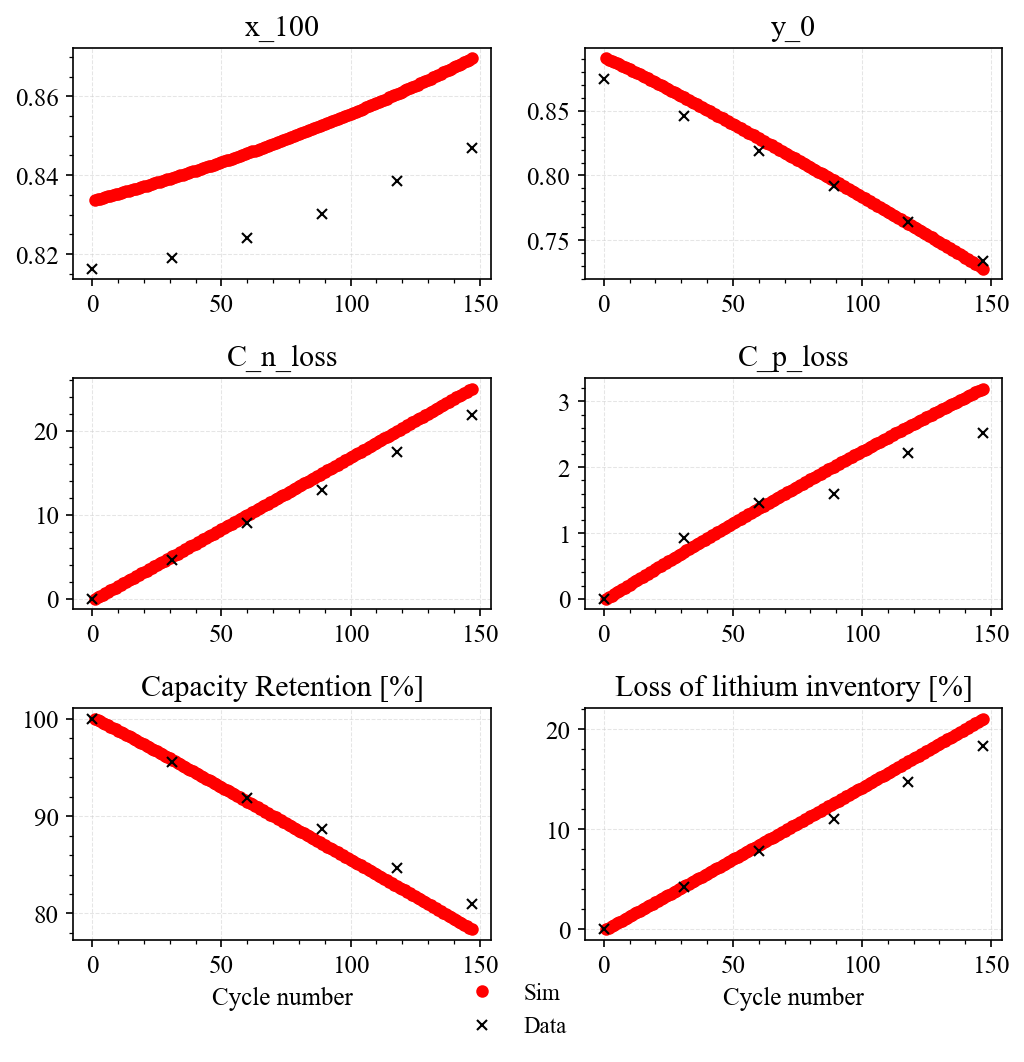

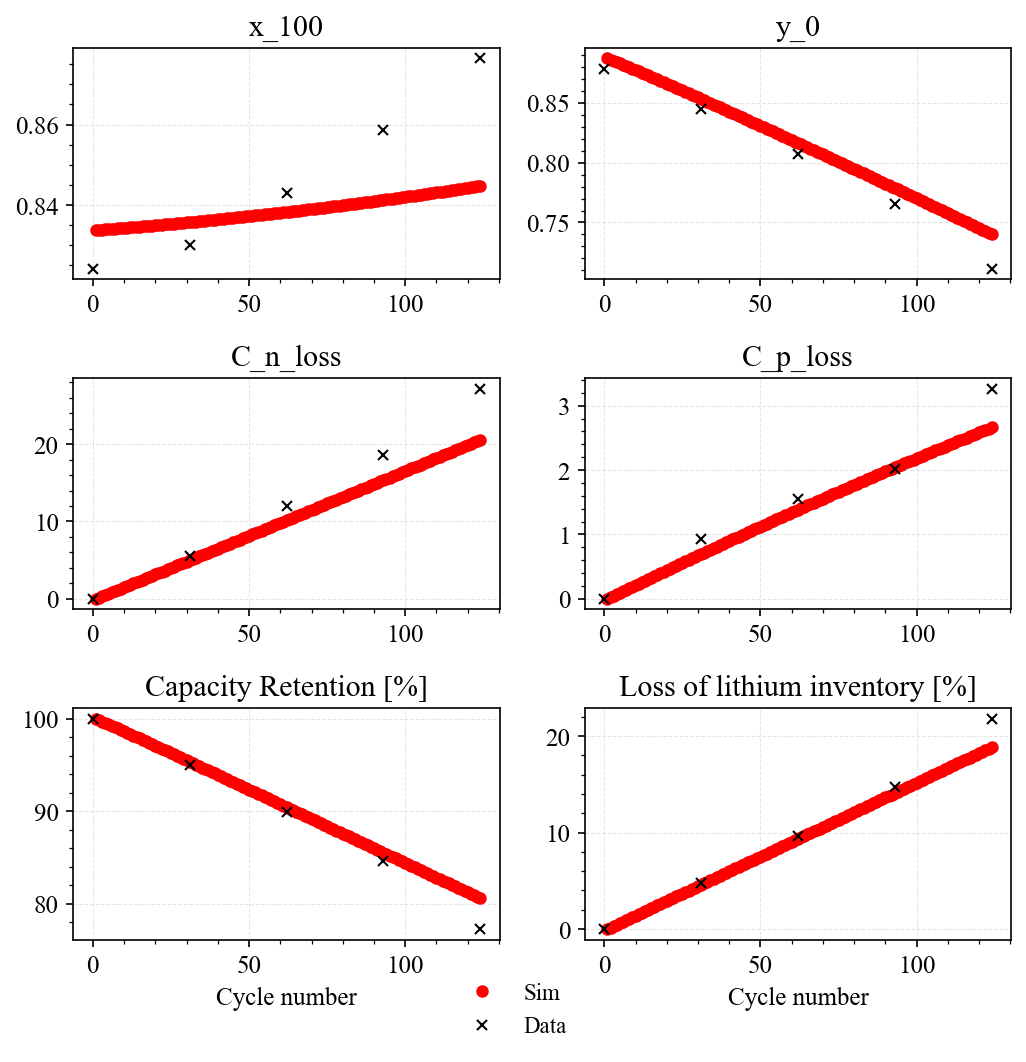

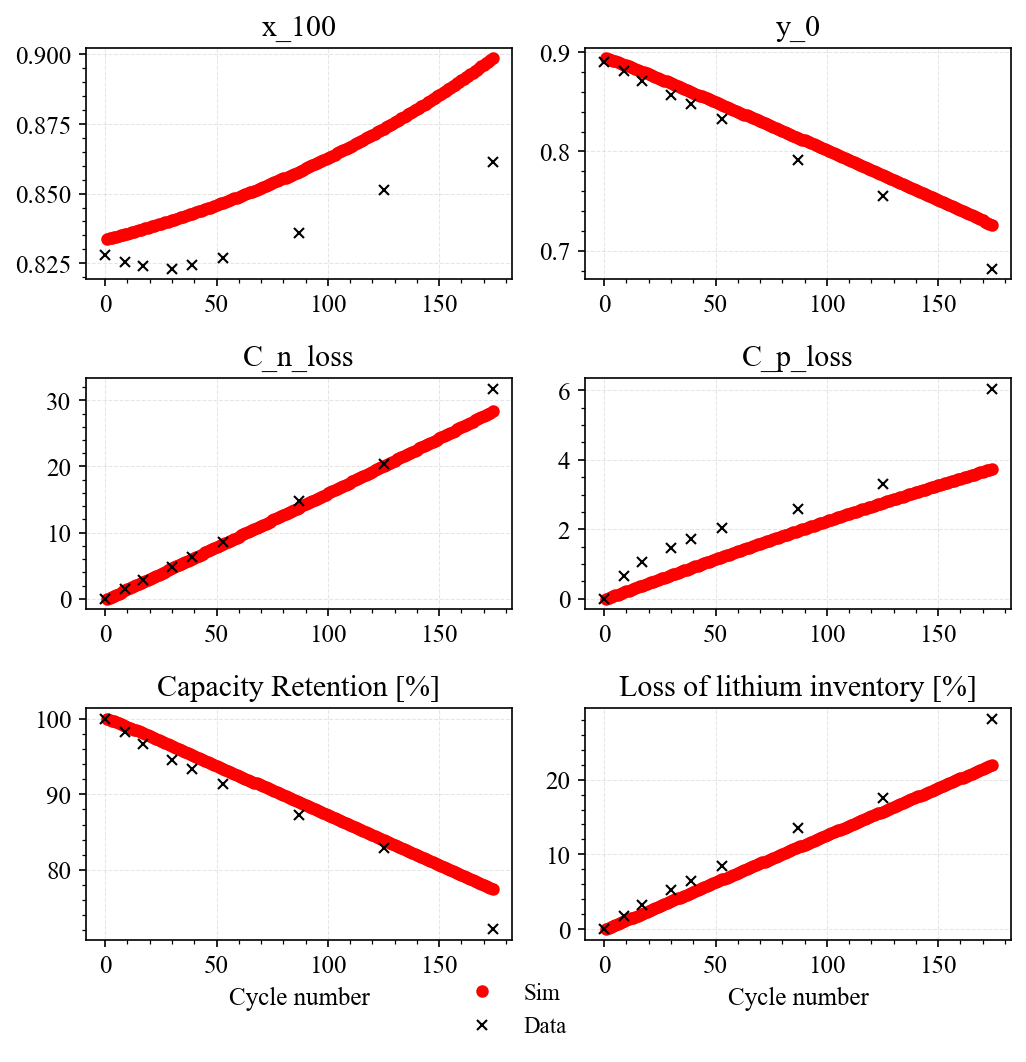

In [22]:
for cell in [3,6,9,12]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/100")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotcn(sol_out,dfe);
    plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

In [23]:
x

array([1.56991983, 2.46595669, 0.51      , 1.73767695])